In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
# from model.vae import aligned_vae, vae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import torch.optim as optim

import diffusion_dist as diff
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from dataset import *
import scipy
import math

# from model.gae import gnn_vae, aligned_gvae, aligned_gae, GraphConvolutionSage

# from model.gae import GraphConvolutionSage
from torch.nn.parameter import Parameter


from model.loss import gae_loss, gvae_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:

class gnn_ae(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout = 0.):
        super(gnn_ae, self).__init__()

        self.gc1 = GraphConvolutionSage(input_feat_dim, hidden_dim1, dropout)
        # the later two layers with activation linear
        self.gc2 = GraphConvolutionSage(hidden_dim1, hidden_dim2, dropout)

        # final layer can be either graph conv or linear
#         self.gc3 = GraphConvolutionSage(hidden_dim2, hidden_dim3, dropout)
        
        self.dc = pairwiseDistDecoder(dropout)



    def reset_parameters(self):
        self.gc1.reset_parameters()
        self.gc2.reset_parameters()
#         self.gc3.reset_parameters()


    def encode(self, x, adj):
        # N * hidden_dim1
        hidden1 = self.gc2(self.gc1(x, adj), adj)
        # mean and variance of the dimension N * hidden_dim2
#         return self.gc3(hidden1, adj)
        return hidden1

    def forward(self, x, adj):
        z = self.encode(x, adj)      
        adj_recon = self.dc(z)
        return adj_recon, z

In [3]:
class GraphConvolutionSage(nn.Module):
    """
    GraphSAGE
    """

    def __init__(self, in_features, out_features, dropout=0.):
        super(GraphConvolutionSage, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout

        self.weight_neigh = Parameter(torch.FloatTensor(out_features, out_features))
        self.weight_self = Parameter(torch.FloatTensor(in_features, out_features))
        self.weight_support = Parameter(torch.FloatTensor(in_features, out_features))
        self.weight_linear = Parameter(torch.FloatTensor(out_features, out_features))


        # with dimension (1, out_features), with broadcast -> (N, Dout)
        self.bias_support = Parameter(torch.FloatTensor(1, out_features))
        self.bias_linear = Parameter(torch.FloatTensor(1, out_features))

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight_neigh)
        torch.nn.init.xavier_uniform_(self.weight_self)
        torch.nn.init.xavier_uniform_(self.weight_support)
        torch.nn.init.xavier_uniform_(self.weight_linear)

        # initialization requires two dimension
        torch.nn.init.xavier_uniform_(self.bias_support)
        torch.nn.init.xavier_uniform_(self.bias_linear)
        

    def forward(self, input, adj):
        # first dropout some inputs
        input = F.dropout(input, self.dropout, self.training)

        # Message: two ways
        support = F.sigmoid(torch.mm(input, self.weight_support) + self.bias_support)

        # Aggregation:
        # addition here, could try element-wise max, make diagonal position 0
        output = torch.mm(adj, support)

        # Update: 
        # output of dimension N * Dout, 
        # tried tanh and relu, not very good result, add one linear layer
        output = F.relu(torch.mm(output, self.weight_neigh) + torch.mm(input, self.weight_self))
        # output = torch.mm(output, self.weight_linear) + self.bias_linear
        
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [4]:
class curr_gae(nn.Module):
    def __init__(self, feature1_dim, feature2_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout = 0.):
        super(curr_gae, self).__init__()

        self.gae1 = gnn_ae(feature1_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout = dropout)
        self.gae2 = gnn_ae(feature2_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout=dropout)
    
    def reset_parameters(self):
        self.gae1.reset_parameters()
        self.gae2.reset_parameters()

    def forward(self, x1, x2, adj1, adj2):
        adj_recon1, z1 = self.gae1(x1, adj1)
        adj_recon2, z2 = self.gae2(x2, adj2)
                
        return adj_recon1, adj_recon2, z1, z2

In [5]:

class pairwiseDistDecoder(nn.Module):
    """Decoder for using pair-wise distance for prediction."""

    def __init__(self, dropout):
        super(pairwiseDistDecoder, self).__init__()
        self.dropout = dropout

    def forward(self, z):
        z = F.dropout(z, self.dropout, training=self.training)
        x_norm = (z**2).sum(1).view(-1, 1)
        y_norm = x_norm.view(1, -1)
        dist = x_norm + y_norm - 2.0 * torch.mm(z, torch.transpose(z, 0, 1))

        return dist 

In [6]:
# atac_dataset_diffmap = graphdata('./data/expr_atac_processed.csv', k = 20,  diff = "diffmap")
# rna_dataset_diffmap = graphdata('./data/expr_rna_processed.csv', k = 20, diff="diffmap")
# torch.save(atac_dataset_diffmap, f= "./data/atac_diffmap.pt")
# torch.save(rna_dataset_diffmap, f = "./data/rna_diffmap.pt")
atac_dataset_diffmap = torch.load(f = "./data/atac_diffmap.pt")
rna_dataset_diffmap = torch.load(f = "./data/rna_diffmap.pt")

In [7]:
# atac_dataset_dpt = graphdata('./data/expr_atac_processed.csv', k = 20,  diff = "dpt")
# rna_dataset_dpt = graphdata('./data/expr_rna_processed.csv', k = 20, diff="dpt")
# torch.save(atac_dataset_dpt, f = "./data/atac_dpt.pt")
# torch.save(rna_dataset_dpt, f = "./data/rna_dpt.pt")
atac_dataset_dpt = torch.load(f = "./data/atac_dpt.pt")
rna_dataset_dpt = torch.load(f = "./data/rna_dpt.pt")

In [8]:
# atac_dataset_dpt = testgraphdata(None, 10)
# rna_dataset_dpt = testgraphdata(None, 10)

In [9]:
# gvae = aligned_gvae(feature1_dim = rna_dataset_diffmap['X'].shape[1], feature2_dim = atac_dataset_diffmap['X'].shape[1], hidden_dim1 = 128, hidden_dim2 = 32, hidden_dim3 = 2, dropout = 0., use_mlp = False, decoder = "distance")

# optimizer = optim.Adam(gvae.parameters(), lr=1e-2, weight_decay=0.01)
# gvae.train()
# gvae.reset_parameters()

# for epoch in range(0, 60):

#     optimizer.zero_grad()

#     dist_rna, dist_atac, latent_rna, latent_atac, logvar_rna, logvar_atac = gvae(rna_dataset_diffmap['X'], atac_dataset_diffmap['X'], rna_dataset_diffmap['similarity'], atac_dataset_diffmap['similarity'])

#     loss, loss_align, loss_dist_atac,  loss_dist_rna, kl_atac, kl_rna = gvae_loss(latent1 = latent_rna, latent2 = latent_atac, adj1 = rna_dataset_diffmap['adj'], adj2 = atac_dataset_diffmap['adj'], recon_adj1 = dist_rna, recon_adj2 = dist_atac, logvar_latent1 = logvar_rna, logvar_latent2 = logvar_atac, lamb_align = 0, lamb_kl = 0, dist_loss_type = "cosine")
#     loss.backward()
#     optimizer.step()
#     # print(latent_rna)

#     if epoch % 10 == 0:
#         log = "Epoch: {:03d}, Total loss: {:.5f}, loss align {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}, KL atac loss: {:.5f}, KL rna loss: {:.5f}"
#         print(log.format(epoch, loss, loss_align, loss_dist_atac, loss_dist_rna, kl_atac, kl_rna))

In [8]:
def mse_loss(latent1, latent2, adj1, adj2, recon_adj1, recon_adj2, lamb_align = 0.01):

    loss_align = lamb_align * torch.norm(latent1 - latent2, p = 'fro')
    
    
    adj1 = adj1 ** 2
    adj2 = adj2 ** 2
    adj1 = (adj1 / torch.norm(adj1, p = 'fro')) 
    adj2 = (adj2 / torch.norm(adj2, p = 'fro')) 
    recon_1 = (recon_adj1 / torch.norm(recon_adj1, p = "fro"))
    recon_2 = (recon_adj2 / torch.norm(recon_adj2, p = "fro")) 

    # mse approx, mse loss change sqrt with mean from norm loss
#     similarity_loss1 = torch.norm(recon_adj1 - adj1, p = "fro") ** 2 / (adj1.shape[0] ** 2)
#     similarity_loss2 = torch.norm(recon_adj2 - adj2, p = "fro") ** 2 / (adj2.shape[0] ** 2)
#     similarity_loss1_2 = F.mse_loss(adj1.reshape(1,-1), recon_1.reshape(1,-1), reduce="mean")
#     similarity_loss2_2 = F.mse_loss(adj2.reshape(1,-1), recon_2.reshape(1,-1), reduce="mean")
    
    similarity_loss1 = torch.norm(recon_adj1 - adj1, p = "fro")
    similarity_loss2 = torch.norm(recon_adj2 - adj2, p = "fro")
    
    loss = loss_align + similarity_loss1 + similarity_loss2 
    
    return loss, loss_align, similarity_loss1,  similarity_loss2

In [13]:
# use distance matrix

gae = curr_gae(feature1_dim = rna_dataset_dpt['X'].shape[1], 
               feature2_dim = atac_dataset_dpt['X'].shape[1], 
               hidden_dim1 = 128, hidden_dim2 = 32, hidden_dim3 = 2, dropout = 0.)

optimizer = optim.Adam(gae.parameters(), lr=1e-4, weight_decay=0.01)
gae.train()
gae.reset_parameters()

In [18]:


for epoch in range(0, 100):

    optimizer.zero_grad()

    dist_rna, dist_atac, latent_rna, latent_atac = gae(rna_dataset_dpt['X'], atac_dataset_dpt['X'], 
                                                       rna_dataset_dpt['similarity'], atac_dataset_dpt['similarity'])

    # loss, loss_align, loss_dist_atac,  loss_dist_rna = gae_loss(latent1 = latent_rna, latent2 = latent_atac, adj1 = rna_dataset_diffmap['adj'], adj2 = atac_dataset_diffmap['adj'], recon_adj1 = dist_rna, recon_adj2 = dist_atac, lamb_align = 1e-3, dist_loss_type = "mse")

    loss, loss_align, loss_dist_atac,  loss_dist_rna = mse_loss(latent1 = latent_rna, latent2 = latent_atac, 
                                                                adj1 = rna_dataset_dpt['adj'], 
                                                                adj2 = atac_dataset_dpt['adj'], 
                                                                recon_adj1 = dist_rna, recon_adj2 = dist_atac, 
                                                                lamb_align = 100)
    loss.backward()
    
    # print(latent_rna)
    
    if epoch % 10 == 0 or epoch == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, loss align {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, loss_align, loss_dist_atac, loss_dist_rna))
        
    
    optimizer.step()

Epoch: 000, Total loss: 3.47641, loss align 1.47398, Dist RNA loss 1.00125, Dist ATAC loss 1.00118
Epoch: 010, Total loss: 3.25998, loss align 1.25767, Dist RNA loss 1.00096, Dist ATAC loss 1.00135
Epoch: 020, Total loss: 4.20955, loss align 2.20734, Dist RNA loss 1.00104, Dist ATAC loss 1.00117
Epoch: 030, Total loss: 3.97806, loss align 1.97613, Dist RNA loss 1.00085, Dist ATAC loss 1.00108
Epoch: 040, Total loss: 4.16220, loss align 2.16022, Dist RNA loss 1.00031, Dist ATAC loss 1.00167
Epoch: 050, Total loss: 3.68893, loss align 1.68748, Dist RNA loss 1.00031, Dist ATAC loss 1.00114
Epoch: 060, Total loss: 3.12239, loss align 1.12166, Dist RNA loss 1.00016, Dist ATAC loss 1.00056
Epoch: 070, Total loss: 4.33767, loss align 2.33645, Dist RNA loss 0.99997, Dist ATAC loss 1.00125
Epoch: 080, Total loss: 3.00484, loss align 1.00460, Dist RNA loss 1.00001, Dist ATAC loss 1.00024
Epoch: 090, Total loss: 3.15522, loss align 1.15511, Dist RNA loss 1.00006, Dist ATAC loss 1.00005


In [19]:
torch.save(gae.state_dict(), "gae_best.ptH")

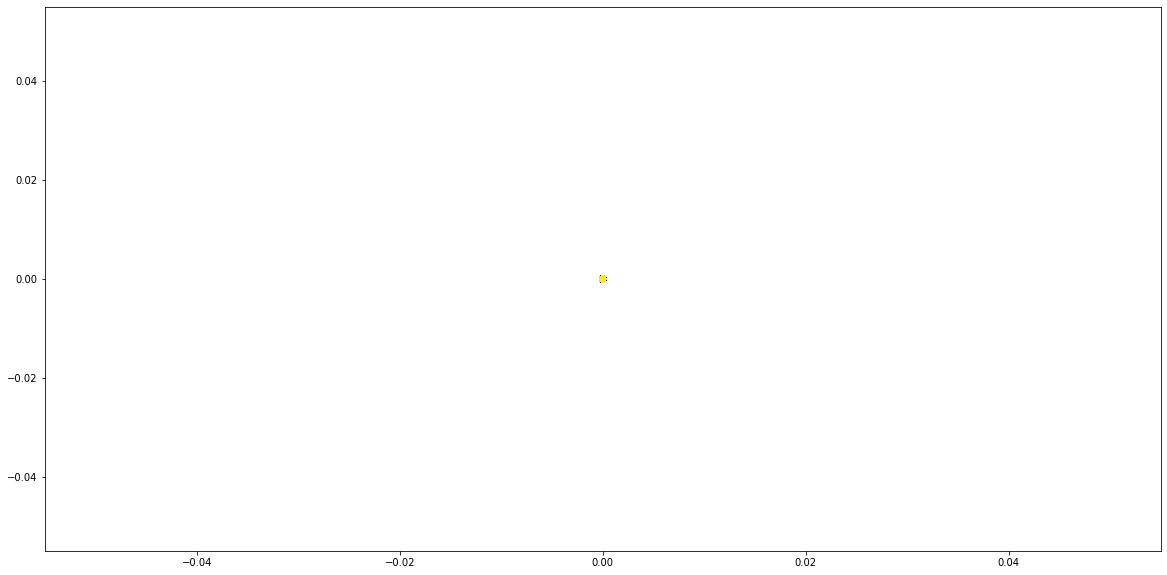

In [32]:
gae.eval()
dist_rna, dist_atac, latent_rna, latent_atac = gae(rna_dataset_dpt['X'], atac_dataset_dpt['X'], 
                                                   rna_dataset_dpt['similarity'], atac_dataset_dpt['similarity'])

z1 = 1e5* latent_rna.detach().cpu().numpy()
z2 = 1e5* latent_atac.detach().cpu().numpy()

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z2[:,0], z2[:,1], c = np.arange(rna_dataset_diffmap['X'].shape[0]))

In [33]:
np.unique(z2)

array([   0.     ,  699.4187 ,  858.73157, 2066.9932 ], dtype=float32)

In [26]:
np.linalg.norm(z2 - z1)

0.020515088